In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [2]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9
                  , -8, -7
                 ], np.nan, inplace=True)

# the columns that stores the labels
labelDimension = "RiskPerformance"

original_rows = features.shape[0]

features = features.dropna(thresh=10) # Remove rows with more than 10 missing values
print("Removed rows:", original_rows - features.shape[0])
features.drop(features.columns[features.isnull().sum() > 1000], axis=1, inplace=True) # Drop columns with more than 1000 values missing

# bins = [0, 20, 40, 60, 80, 100]
# labels =[0, 1, 2, 3, 4]
# features['ExternalRiskEstimateCat'] = pd.cut(features['ExternalRiskEstimate'], bins, labels=labels)

categorical = [
#     'ExternalRiskEstimateCat', 
    'MaxDelqEver', 
    'MaxDelq/PublicRecLast12M'
]

X = features[features.columns[1:]]
numerical = [col for col in X.columns if col not in categorical]

y = features[labelDimension]
y_code = y.astype("category").cat.codes # Int representation of labels
for cat in categorical:
    X[cat] = X[cat].astype("category")

Removed rows: 588


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

imputer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical), 
    ('cat', SimpleImputer(strategy='most_frequent'), categorical)
])

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transformer = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])

In [4]:
columns = list(numerical) + list(categorical)
X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.8, random_state=0)

# Impute values
X_np = imputer.fit_transform(X)
X = pd.DataFrame(X_np, columns=columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.8, random_state=0)

In [5]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
labelled_correctly = y_pred == y_test
y_pred_prob = model.predict_proba(X_test)[:, 1]

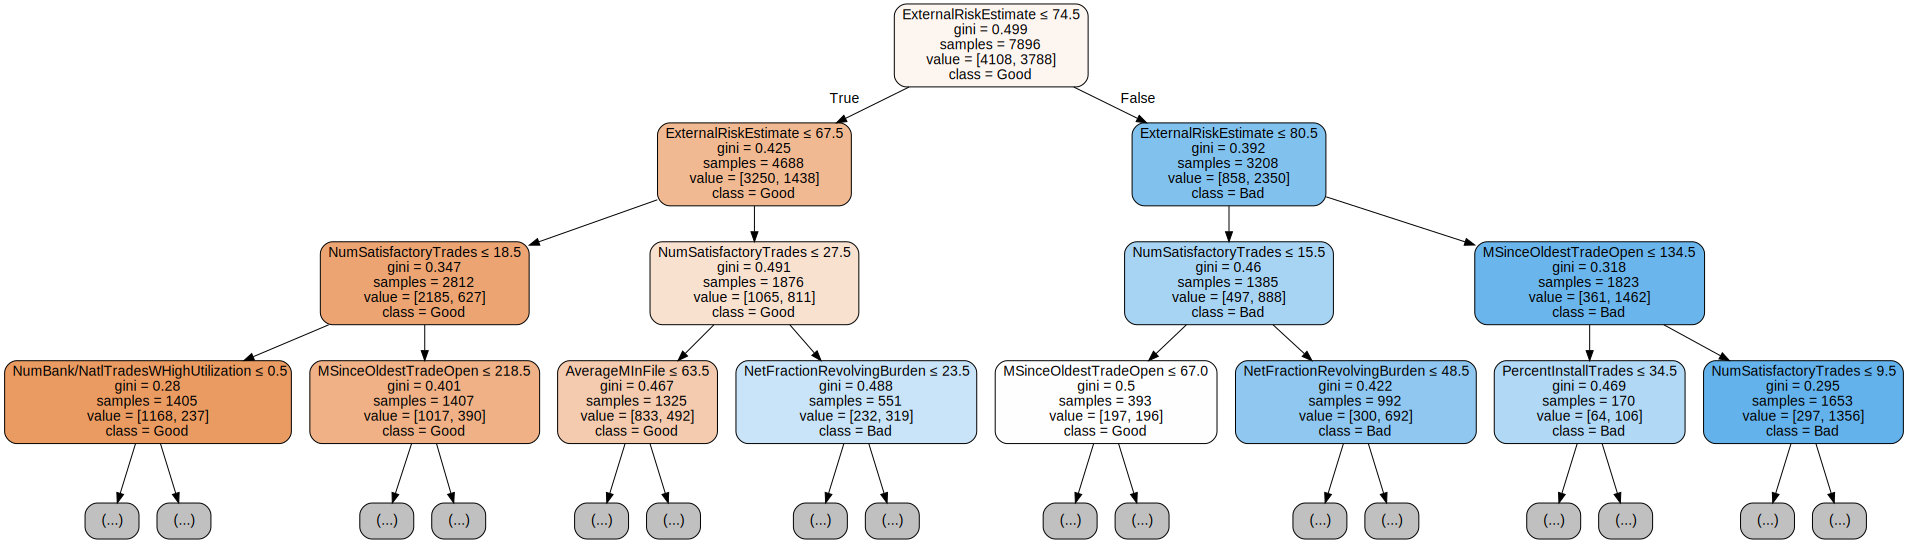

In [9]:
from sklearn.datasets import load_iris
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
# Extract single tree
estimator = model.base_estimator_.fit(X_train, y_train)

from sklearn.tree import export_graphviz

dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names= X.columns,  
                                class_names=['Good', 'Bad'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=3, leaves_parallel=True)  
graph = graphviz.Source(dot_data)
graph.render("decisiontree_final")
#print(model)
graph 
